In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import yfinance as yf
sns.set()

In [2]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

yfinance==0.1.55
numpy==1.18.5
seaborn==0.10.1
pandas==1.0.5
matplotlib==3.3.0


In [3]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [4]:
bbri = yf.Ticker("BBRI.JK")
bbri = bbri.history(period="max")
bbri = bbri.reset_index()

In [5]:
bbri.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2003-11-10,1.478751,1.549168,1.337918,1.373126,5144140000,0.0,0.0
1,2003-11-11,1.373126,1.408335,1.337918,1.408335,2938555000,0.0,0.0
2,2003-11-12,1.373126,1.478751,1.373126,1.478751,2002915000,0.0,0.0
3,2003-11-13,1.478751,1.478751,1.443543,1.478751,1190050000,0.0,0.0
4,2003-11-14,1.478751,1.478751,1.408334,1.478751,1725265000,0.0,0.0


## Dataset Tahun 2020 Hingga 11 November 2020

In [6]:
bbri_2 = yf.download('BBRI.JK', 
                      start='2020-01-01', 
                      end='2020-11-18', 
                      progress=False)
bbri_2.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-11,3970.0,4190.0,3950.0,4120.0,4120.0,357098000
2020-11-12,4100.0,4100.0,3920.0,3950.0,3950.0,333297500
2020-11-13,3970.0,4080.0,3960.0,4000.0,4000.0,237374000
2020-11-16,4050.0,4070.0,3930.0,3960.0,3960.0,193022100
2020-11-17,4000.0,4020.0,3930.0,3960.0,3960.0,180851100


In [7]:
close = bbri_2.Close.values.tolist()
window_size = 30
skip = 1
l = len(close) - 1

In [8]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [9]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, money, max_buy, max_sell):
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [10]:
model = Model(window_size, 500, 3)
agent = Agent(model, 10000, 5, 5)
agent.fit(500, 10)

iter 10. reward: -235.600000
iter 20. reward: -6.800000
iter 30. reward: 23.800000
iter 40. reward: 111.900000
iter 50. reward: 111.700000
iter 60. reward: 82.200000
iter 70. reward: 108.800000
iter 80. reward: 138.000000
iter 90. reward: -34.300000
iter 100. reward: 124.300000
iter 110. reward: 129.600000
iter 120. reward: 175.300000
iter 130. reward: 163.900000
iter 140. reward: 99.900000
iter 150. reward: 158.600000
iter 160. reward: 163.300000
iter 170. reward: 165.300000
iter 180. reward: 190.600000
iter 190. reward: 214.900000
iter 200. reward: 228.400000
iter 210. reward: 237.600000
iter 220. reward: 228.500000
iter 230. reward: 242.900000
iter 240. reward: 231.800000
iter 250. reward: 252.200000
iter 260. reward: 260.500000
iter 270. reward: 259.000000
iter 280. reward: 285.600000
iter 290. reward: 275.200000
iter 300. reward: 292.200000
iter 310. reward: 306.100000
iter 320. reward: 290.600000
iter 330. reward: 325.400000
iter 340. reward: 306.500000
iter 350. reward: 326.9000

day 2: buy 5 units at price 21850.000000, total balance -11850.000000
day 4, sell 5 units at price 21900.000000, investment 0.228833 %, total balance 10050.000000,
day 5: buy 5 units at price 22000.000000, total balance -11950.000000
day 15, sell 5 units at price 23700.000000, investment 7.727273 %, total balance 11750.000000,
day 18: buy 5 units at price 23100.000000, total balance -11350.000000
day 19, sell 5 units at price 23100.000000, investment 0.000000 %, total balance 11750.000000,
day 22: buy 1 units at price 4460.000000, total balance 7290.000000
day 23, sell 1 units at price 4560.000000, investment 2.242152 %, total balance 11850.000000,
day 25: buy 1 units at price 4550.000000, total balance 7300.000000
day 27: buy 5 units at price 22500.000000, total balance -15200.000000
day 29, sell 5 units at price 22650.000000, investment 397.802198 %, total balance 7450.000000,
day 30: buy 1 units at price 4570.000000, total balance 2880.000000
day 32, sell 2 units at price 8940.00000

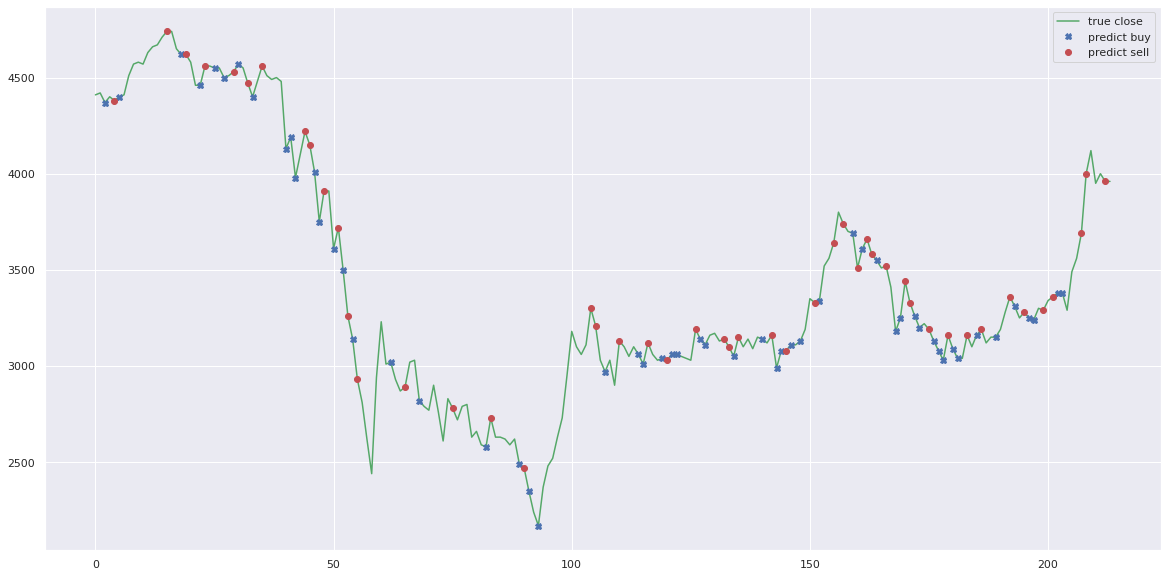

In [11]:
agent.buy()